In [2]:
import sys
from pathlib import Path
import os 
sys.path.append('/home/gridsan/vyuan/.local/lib/python3.9/site-packages/')

current_path = Path.cwd()

# Go to top of the root and append
root = current_path.parents[4]
sys.path.append(str(root))

os.chdir(root)

In [3]:
import os
import json
from pathlib import Path

import torch

from fairness_cv_project.methods.label_free_cbm.src.utils import data_utils
from fairness_cv_project.methods.label_free_cbm.src.models import cbm
from fairness_cv_project.methods.label_free_cbm.src.plots import plots

In [4]:
# change this to the correct model dir, everything else should be taken care of
load_dir = "saved_models/imSitu/30_verbs/CBM/no_gender/sparse_balanced/imSitu_30_balanced_imSitu_30_filtered"
device = "cuda"

with open(os.path.join(load_dir, "args.txt"), "r") as f:
    args = json.load(f)
dataset = args["dataset"]
target_model, target_preprocess = data_utils.get_target_model(args["backbone"], device)
model = cbm.load_cbm(load_dir, device)

In [5]:
val_d_probe = dataset+"_val"
cls_file = data_utils.LABEL_FILES[dataset]

val_data_t = data_utils.get_data(val_d_probe, preprocess=target_preprocess)
val_pil_data = data_utils.get_data(val_d_probe)

In [6]:
with open(cls_file, "r") as f:
    classes = f.read().split("\n")

with open(os.path.join(load_dir, "concepts.txt"), "r") as f:
    concepts = f.read().split("\n")

## Original prediction

In [7]:
from torchvision import transforms

In [8]:
val_pil_data

Dataset ImageFolder
    Number of datapoints: 1140
    Root location: data/datasets/imSitu/data/30_verbs/train_val_split/train_balanced/val

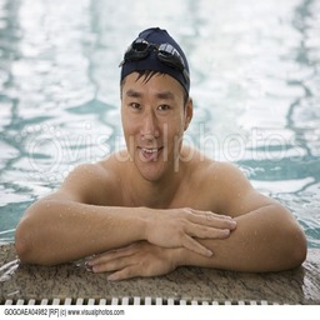

Image:500 Gt:leaning, 1st Pred:hugging, 1.760, 2nd Pred:carrying, 1.561


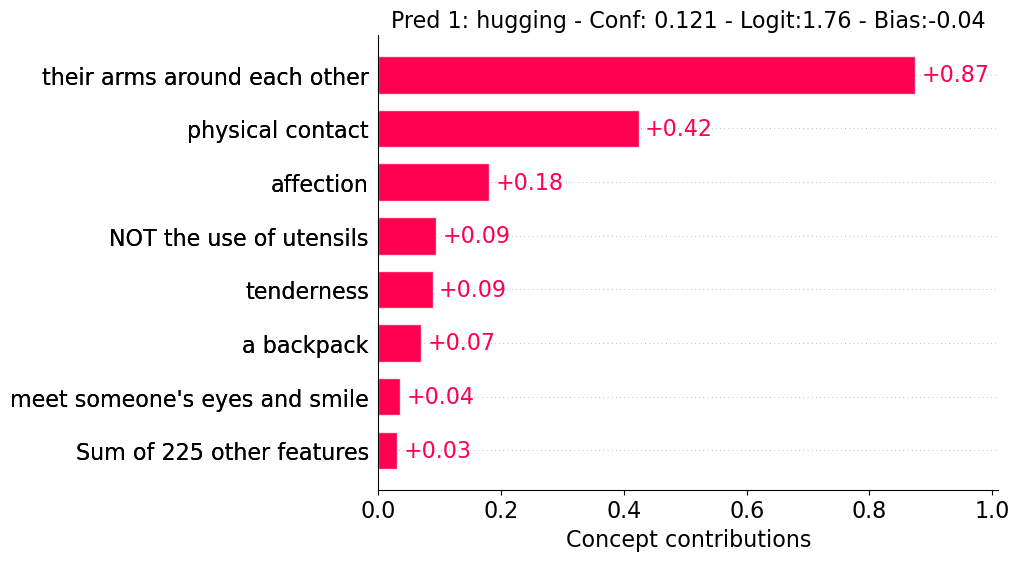

AttributeError: 'NoneType' object has no attribute 'savefig'

In [10]:
to_display = [500]

with torch.no_grad():
    for i in to_display:
        image, label = val_pil_data[i]
        x, _ = val_data_t[i]
        # For doctor nurse
        x = x.unsqueeze(0).to(device)
        
        # For imSitu
        #x = transforms.ToTensor()(x).unsqueeze(0).to(device)
        display(image.resize([320,320]))
        outputs, concept_act = model(x)
        
        top_logit_vals, top_classes = torch.topk(outputs[0], dim=0, k=2)
        conf = torch.nn.functional.softmax(outputs[0], dim=0)
        print("Image:{} Gt:{}, 1st Pred:{}, {:.3f}, 2nd Pred:{}, {:.3f}".format(i, classes[int(label)], classes[top_classes[0]], top_logit_vals[0],
                                                                      classes[top_classes[1]], top_logit_vals[1]))
        
        for k in range(2):
            contributions = concept_act[0]*model.final.weight[top_classes[k], :]
            feature_names = [("NOT " if concept_act[0][i] < 0 else "") + concepts[i] for i in range(len(concepts))]
            values = contributions.cpu().numpy()
            # max_display = min(int(sum(abs(values)>0.005))+1, 8)
            max_display = 8
            title = "Pred {}: {} - Conf: {:.3f} - Logit:{:.2f} - Bias:{:.2f}".format(k+1, classes[top_classes[k]],
                             conf[top_classes[k]], top_logit_vals[k], model.final.bias[top_classes[k]])
            pl = plots.bar(values, feature_names, max_display=max_display, title=title, fontsize=16)
            pl.savefig('leaning.png')
            break

## Intervene on "a hat" to correct prediction

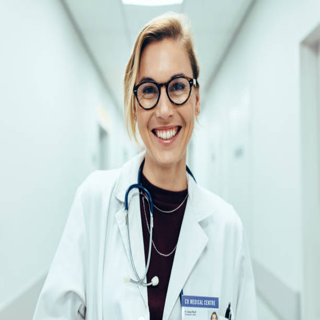

ValueError: 'a hat' is not in list

In [8]:
to_display = [2]

with torch.no_grad():
    for i in to_display:
        image, label = val_pil_data[i]
        x, _ = val_data_t[i]
        x = x.unsqueeze(0).to(device)
        display(image.resize([320,320]))
        
        _, concept_act = model(x)
        # Intervene to change hat activation to 0
        concept_act[0, concepts.index("a hat")] = 0
        outputs = model.final(concept_act)
        
        top_logit_vals, top_classes = torch.topk(outputs[0], dim=0, k=2)
        conf = torch.nn.functional.softmax(outputs[0], dim=0)
        print("Image:{} Gt:{}, 1st Pred:{}, {:.3f}, 2nd Pred:{}, {:.3f}".format(i, classes[int(label)], classes[top_classes[0]], top_logit_vals[0],
                                                                      classes[top_classes[1]], top_logit_vals[1]))
        
        for k in range(2):
            contributions = concept_act[0]*model.final.weight[top_classes[k], :]
            feature_names = [("NOT " if concept_act[0][i] < 0 else "") + concepts[i] for i in range(len(concepts))]
            values = contributions.cpu().numpy()
            max_display = min(int(sum(abs(values)>0.005))+1, 8)
            title = "Pred {}: {} - Conf: {:.3f} - Logit:{:.2f} - Bias:{:.2f}".format(k+1, classes[top_classes[k]],
                             conf[top_classes[k]], top_logit_vals[k], model.final.bias[top_classes[k]])
            plots.bar(values, feature_names, max_display=max_display, title=title, fontsize=16)